<a href="https://colab.research.google.com/github/alleyex/tensorflow_lab/blob/main/using_a_mulit_layer_lstm_for_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Utilities

def plot_series(time, series, format = '-', start = 0 , end = None):

  # Setup dimensions of the graph figure
  plt.figure(figsize = (10, 8))

  if type(series) is tuple:

    for series_num in series:

      # Plot the time series data
      plt.plot(time[start: end], series_num[start: end])
  else:
    # Plot the time series data
    plt.plot(time[start: end], series[start: end])

  # Overlay a grid on the graph
  plt.grid(True)

  # Label the x-axis
  plt.xlabel("Time")
  # Label the y-axis
  plt.ylabel("Value")

  # Draw the graph on screen
  plt.show()

def trend(time, slope = 0):

  # Compute the linear series given the slope
  series = time * slope

  return series

def seasonal_pattern(season_time):

  # Generate the values using an arbitrary pattern
  data_pattern = np.where(season_time < 0.4, np.cos(season_time * 3 * np.pi), 1 / np.exp(3 * season_time))

  return data_pattern

def seasonality(time, period, amplitude = 1, phase = 0):

  # Define the measured values per period
  season_time = ((time + phase) % period) /  period

  # Generates the seasonal data scaled by the defined amplitude
  data_pattern = amplitude * seasonal_pattern(season_time)

  return data_pattern

def noise(time, noise_level, seed = None):

  # Initialize the random number generater
  rnd = np.random.RandomState(seed)
  # Generate a random number for each time step and scale by the noise level
  noise = rnd.randn(len(time)) * noise_level

  return noise

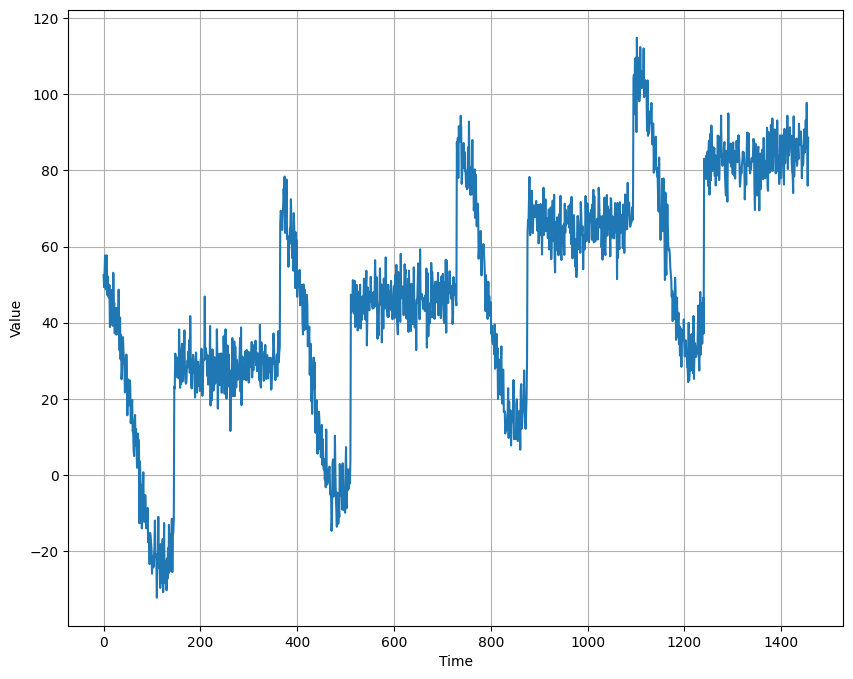

In [ ]:
# Generate the Synthetic Data
# Parameters
time = np.arange(364 * 4 + 1, dtype = 'float32')
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)
series += noise(time, noise_level, seed = 42)

# Plot the results
plot_series(time, series)


In [ ]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  # Generate a TF Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the data but only take those with the specified size
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # Create tuples with features and labels
  dataset = dataset.map(lambda window: (window[: -1], window[-1]))

  # Shuffle the windows
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [ ]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
# Print shapes of feature and label
for window in dataset.take(1):
  print(f"shape of feature: {window[0].shape}")
  print(f"shpae of label: {window[1].shape}")

shape of feature: (32, 20)
shpae of label: (32,)


In [ ]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_tune.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 20, 1)             0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 20, 64)            8704      
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 lambda_3 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33601 (131.25 KB)
Trainable params: 3360

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

model_tune.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer)

history = model_tune.fit(dataset, epochs = 100, callbacks = [lr_schedule])


(1e-08, 0.001, 0.0, 50.0)

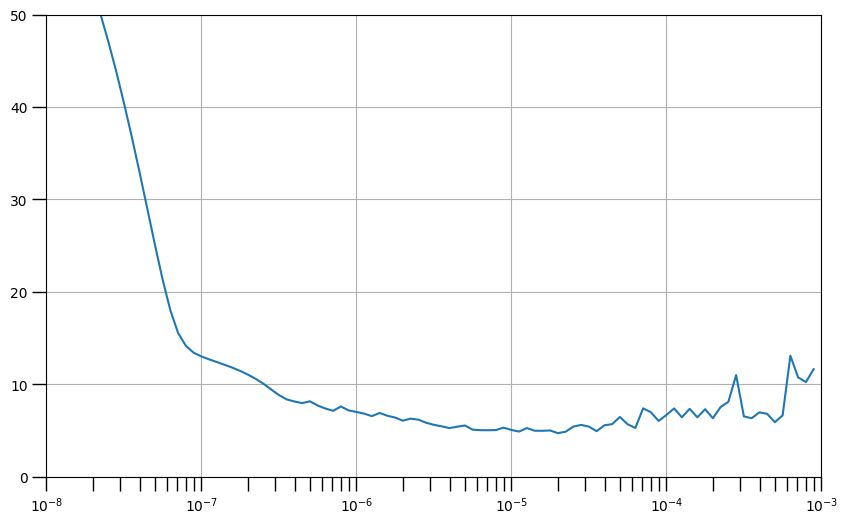

In [ ]:
lrs = 1e-8 * 10**(np.arange(100) / 20)

plt.figure(figsize = (10, 6))

plt.grid(True)

plt.semilogx(lrs, history.history['loss'])
plt.tick_params('both', length = 10, width = 1, which = 'both')
plt.axis([1e-8, 1e-3, 0, 50])

(1e-07, 0.001, 0.0, 20.0)

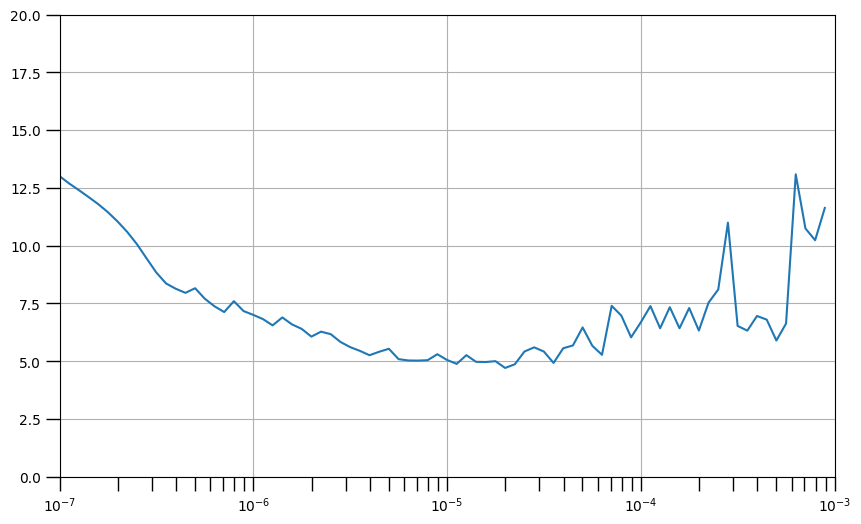

In [ ]:
# Define the learning rate rate array
lrs = 1e-8 * 10**(np.arange(100) / 20)

# Set the figure size
plt.figure(figsize = (10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history['loss'])

# Increase the tickmarks size
plt.tick_params('both', length = 10, width = 1, which = 'both')

# Set the plot boundaries
plt.axis([1e-7, 1e-3, 0, 20])

In [ ]:
# Reset states generated by keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirection  (None, None, 64)          8704      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33601 (131.25 KB)
Trainable params: 33601 

In [ ]:
learning_rate = 1e-5

optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer, metrics = ["mae"])

history = model.fit(dataset, epochs = 100, )

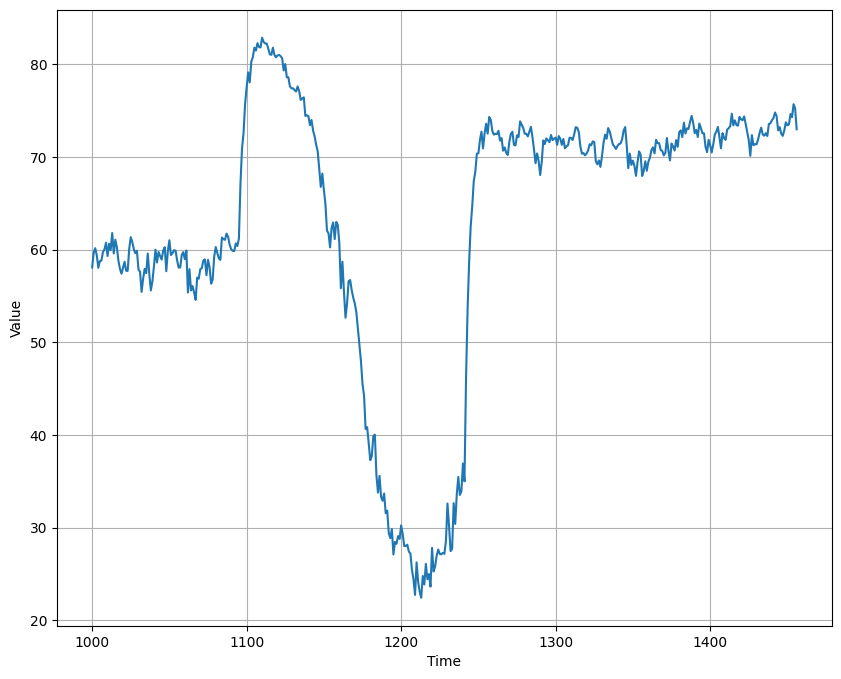

In [ ]:
# Prediction
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time: time + window_size][np.newaxis], verbose = 0))

results = np.array(forecast).squeeze()

plot_series(time_valid, results)

In [ ]:
def model_forecast(model, series, window_size, batch_size):

  # Generate a TF Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the data but only take those those with the spectified size
  dataset = dataset.window(window_size, shift = 1, drop_remainder = True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size))

  # Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  # Get predictions on the entire dataset
  forecast = model.predict(dataset)

  return forecast


15/15 [==============================] - 2s 20ms/step


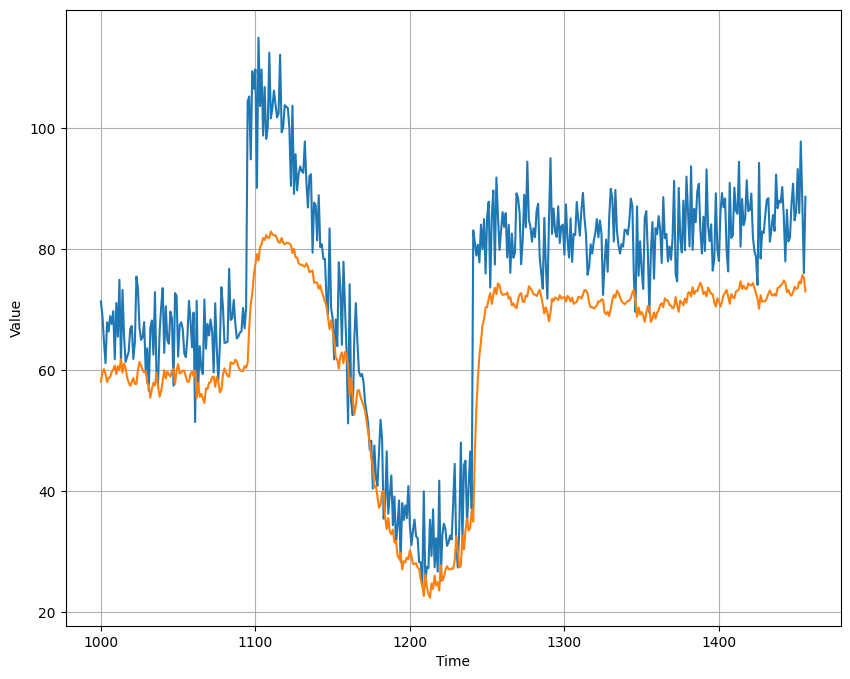

In [ ]:
# Reduce the original series
forecast_series = series[split_time - window_size: -1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))


In [ ]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

165.10938
10.729369
